<font size = 10> **Creating a mask for MEASO regions** </font>

# Loading relevant libraries

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

In [2]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
import regionmask
import numpy as np
import UsefulFunctions as uf
import pandas as pd

# Loading shapefile with MEASO regions
The mask for the MEASO regions was created based on shapefile from the `measoshapes` R package.

<AxesSubplot:>

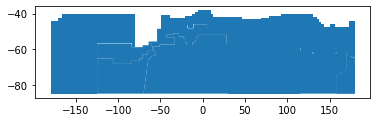

In [3]:
#Note that the full file path is being used.
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo_wgs84.shp')
regions = regions.query('zone != "Temperate"')
regions
        
#Checking results
regions.plot()

In [12]:
regions

,name,sector,zone,fill,LongName,geometry
0,WPA,West Pacific,Antarctic,#016074FF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
1,WPA,West Pacific,Antarctic,#BCECFEFF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
2,WPS,West Pacific,Subantarctic,#1094AFFF,West Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -128.00000 -65..."
3,WPN,West Pacific,Northern,#054e70FF,West Pacific Northern,"POLYGON ((-125.00000 -40.00000, -125.00000 -56..."
5,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,"POLYGON ((-125.00000 -85.00000, -125.00000 -65..."
6,EPS,East Pacific,Subantarctic,#5F9EA0FF,East Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -125.00000 -56..."
7,EPN,East Pacific,Northern,#4B7D7EFF,East Pacific Northern,"POLYGON ((-125.00000 -56.80000, -125.00000 -40..."
9,AOA,Atlantic,Antarctic,#BCECFEFF,Atlantic Antarctic,"POLYGON ((-59.00000 -59.40791, -59.00000 -58.6..."
11,AOS,Atlantic,Subantarctic,#1094AFFF,Atlantic Subantarctic,"POLYGON ((30.00000 -56.50000, 28.00000 -56.500..."
12,AON,Atlantic,Northern,#054e70FF,Atlantic Northern,"POLYGON ((30.00000 -41.70000, 30.00000 -47.900..."


# Loading ACCESS-OM2 data sample for the Southern Ocean 

In [4]:
#Accessing COSIMA cookbook
import cosima_cookbook as cc
session = cc.database.create_session()

#Loading data
data =  cc.querying.getvar('01deg_jra55v140_iaf_cycle2', 'area_t', 
                           session, frequency = 'static', n = -1)
data = data.sel(yt_ocean = slice(-80, -35))
data = uf.corrlong(data)
data

<xarray.DataArray 'area_t' (yt_ocean: 844, xt_ocean: 3600)>
dask.array<getitem, shape=(844, 3600), dtype=float32, chunksize=(513, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-08-20
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

# Checking MEASO regions and ACCESS-OM2 data are correctly aligned

<AxesSubplot:xlabel='xt_ocean', ylabel='tcell latitude [degrees_N]'>

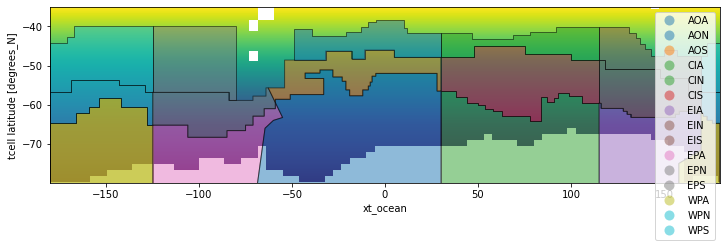

In [5]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
data.plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

# Creating an xarray mask of the MEASO regions

## Getting latitude and longitude values from target grid

In [7]:
# Extracting latitude and longitude values from SO data array
lon = data['xt_ocean'].values
lat = data['yt_ocean'].values

## Creating mask using shapefile and model grid coordinates

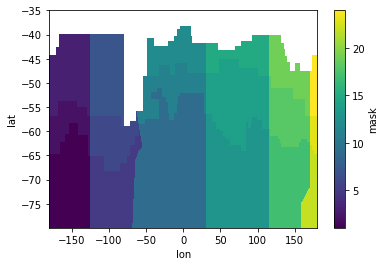

In [11]:
#Creating a 3D mask, which includes regions as a dimension
mask2D = regionmask.mask_geopandas(regions, lon, lat)
#Plotting all regions within mask to check they are correct
mask2D.plot()

## Renaming regions
When the mask was created, numeric values were assigned to the `region` dimension which correspond to their index in the shapefile used to create the mask. In this step, regions will be renamed so the shorten version of its name (column `name` in the shapefile) will appear as the value in the `region` dimension of the mask.

In [28]:
#Getting names of regions from the shapefile to include them in mask (keep the same order as they appear)
# reg_names = regions.loc[:,['name', 'LongName']]
# # .LongName.values.tolist()
# reg_names['ID'] = regions.index
reg_names.drop_duplicates('name')
#Replacing numbered regions for names in the mask
# mask3D['region'] = reg_names

# #Checking results
# mask3D.region

,name,LongName,ID
0,WPA,West Pacific Antarctic,0
2,WPS,West Pacific Subantarctic,2
3,WPN,West Pacific Northern,3
5,EPA,East Pacific Antarctic,5
6,EPS,East Pacific Subantarctic,6
7,EPN,East Pacific Northern,7
9,AOA,Atlantic Antarctic,9
11,AOS,Atlantic Subantarctic,11
12,AON,Atlantic Northern,12
13,CIA,Central Indian Antarctic,13


In [ ]:
reg_names 

## Merging duplicate West Pacific areas
Areas within the West Pacific sector appear twice in the mask. This is because these areas are split in two along the -180/+180 longitude boundary.  
Areas with the same name will be summed together. Since each area is a boolean, the resulting data array will include `True` only for pixels within the boundaries of each area.  
*Remember boolean data represent `True` as `1` and `False` as `0`.*

In [21]:
#Creating a list of repeated sectors
import collections
repeated = [i for i, count in collections.Counter(mask3D.region.values).items() if count > 1]

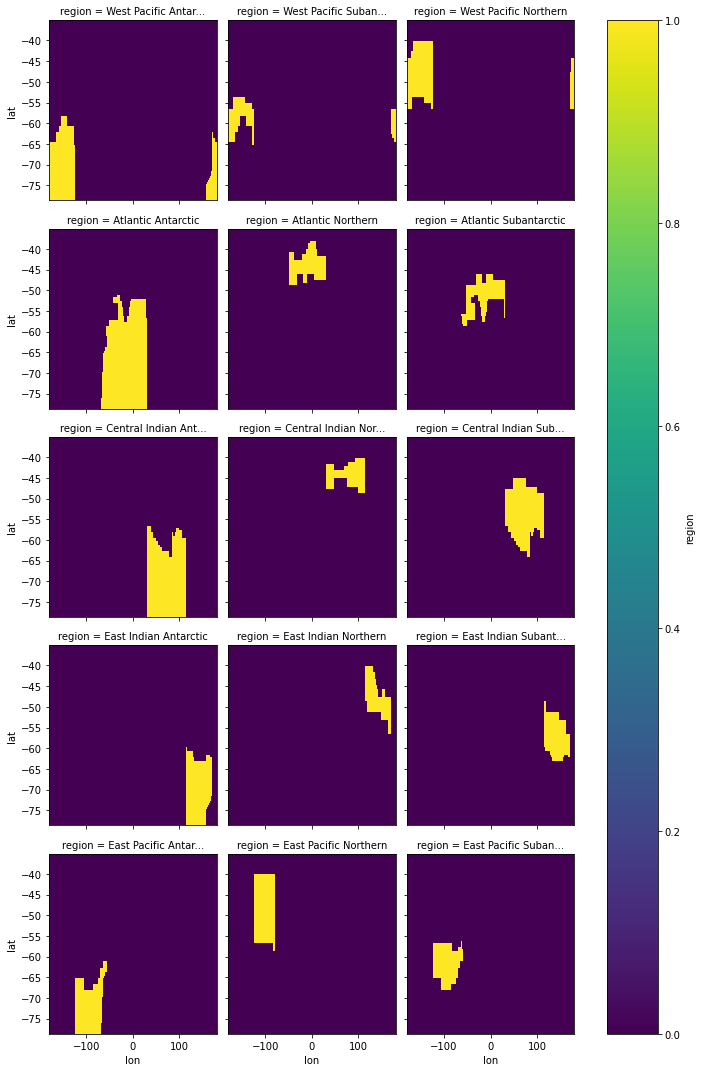

In [22]:
#Creating an empty variable to store the corrected areas
corr_reg = []

#We will loop through each repeated area
for i in repeated:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i).sum('region')
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)

#Appending all other regions
non_rep = sorted([sec for sec in set(mask3D.region.values) if sec not in repeated])
for i in non_rep:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i)
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)
        
#Concatenate all information into one new data array
corrected_mask = xr.concat(corr_reg, 'region')

#Checking the final result, which should include 25 areas in total
corrected_mask.plot(col = 'region', col_wrap = 3)

### Additional steps if longitude needs to be between 0-360 degrees

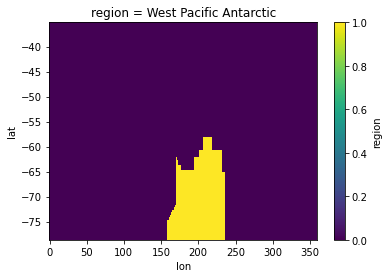

In [23]:
corr_lon = copy.deepcopy(corrected_mask.lon.values)
corr_lon[np.where(corr_lon < 0)] = sorted(corr_lon[np.where(corr_lon < 0)]+360)
corrected_mask.coords['lon'] = corr_lon
corrected_mask = corrected_mask.sortby(corrected_mask.lon)
corrected_mask[0].plot()

## Replacing zero values with NaN

In [24]:
corrected_mask = corrected_mask.where(corrected_mask != 0)

## Renaming coordinate dimensions
Coordinate dimensions are renamed so they match the names in ACCESS-ESM1.5.

In [17]:
corrected_mask = corrected_mask.rename({'lon': 'xt_ocean','lat': 'yt_ocean'})

## Checking mask has been correctly calculated

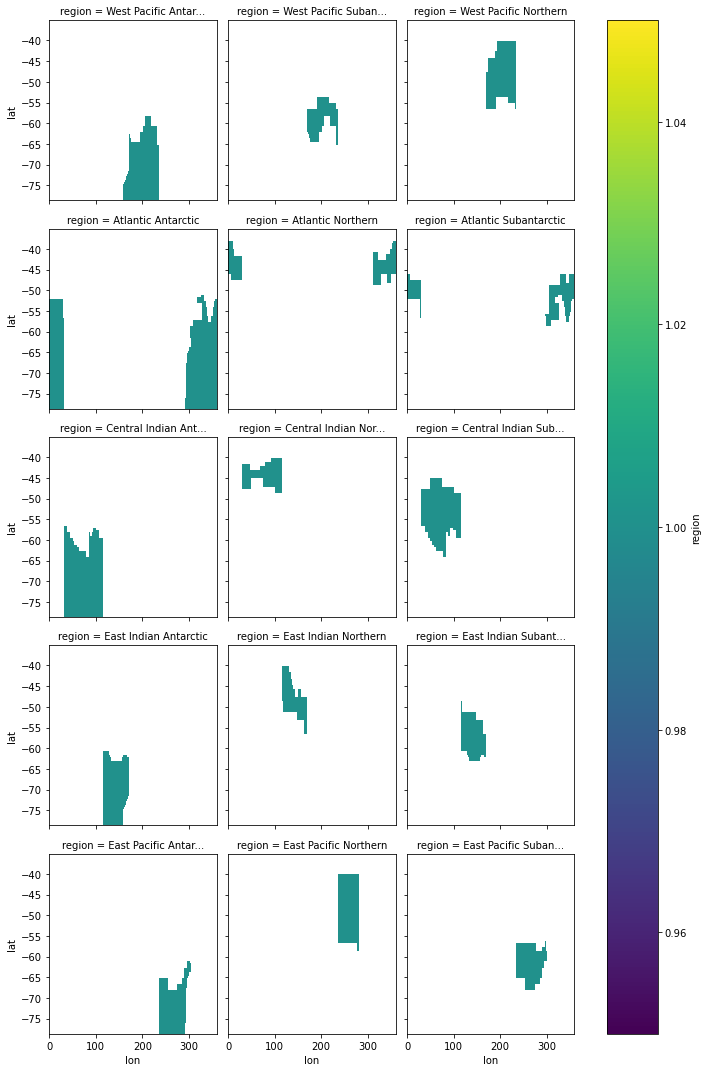

In [25]:
corrected_mask.plot(col = 'region', col_wrap = 3)

## Saving the resulting mask

In [107]:
corrected_mask.to_netcdf('MEASO_3Dmask.nc')
# corrected_mask.to_netcdf('MEASO_3Dmask_regridded.nc')